# <center style='color:coral'>Deep Convolutional Generative Adversarial Network (`DCGAN`) using PyTorch - Example with `FashionMNIST` dataset</center>

# 1. Import required libraries

In [1]:
import torch
print('PyTorch version:', torch.__version__)
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

import torchvision
print('Torchvision version:', torchvision.__version__)
from torchvision import datasets, transforms
from torchvision.utils import make_grid

from torchinfo import summary

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

PyTorch version: 2.0.1+cu117
Torchvision version: 0.15.2+cu117


# 2. Define the device

In [2]:
print('GPU name:', torch.cuda.get_device_name(), '\n')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device is:', device, '\n')
print('Total number of GPUs:', torch.cuda.device_count())

GPU name: NVIDIA RTX A5000 

Device is: cuda 

Total number of GPUs: 1


# 3. Load `FashionMNIST` dataset

In [3]:
transform = transforms.Compose([transforms.Resize((64, 64)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5,), std=(0.5,))])

In [4]:
fmnist_dataset = datasets.FashionMNIST(root='./data_src', train=True, download=True, transform=transform)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26421880/26421880 [00:24<00:00, 1077877.25it/s]


Extracting ./data_src/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data_src/FashionMNIST/raw



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29515/29515 [00:00<00:00, 109627.31it/s]


Extracting ./data_src/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data_src/FashionMNIST/raw



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4422102/4422102 [00:10<00:00, 422696.03it/s]


Extracting ./data_src/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data_src/FashionMNIST/raw



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5148/5148 [00:00<00:00, 15489438.30it/s]

Extracting ./data_src/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data_src/FashionMNIST/raw



In [5]:
print('Length of the FashionMNIST (training) dataset:', len(fmnist_dataset))

Length of the FashionMNIST (training) dataset: 60000


In [6]:
print('Shape of the FashionMNIST (training) dataset:', fmnist_dataset.data.shape)

Shape of the FashionMNIST (training) dataset: torch.Size([60000, 28, 28])


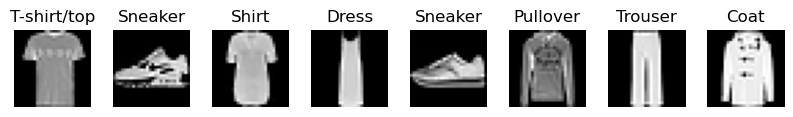

In [7]:
# show 8 randomly selected samples from the FashionMNIST (training) dataset

fig, axis = plt.subplots(nrows=1, ncols=8, figsize=(10, 1))

for ax, _ in zip(axis.ravel(), range(8)):
    inx = np.random.randint(len(fmnist_dataset))
    ax.imshow(fmnist_dataset.data[inx], cmap='gray')
    ax.set_title(fmnist_dataset.classes[fmnist_dataset.targets[inx]], fontsize=12)
    ax.axis(False);

# 4. Define dataloader

In [8]:
data_loader = DataLoader(fmnist_dataset, batch_size=256, shuffle=True, drop_last=True)

In [9]:
print('Length of the dataloader (training):', len(data_loader))

Length of the dataloader (training): 234


# 5. Create `DISCRIMINATOR` architecture

In [10]:
class DISCRIMINATOR(nn.Module):
    def __init__(self):
        super(DISCRIMINATOR, self).__init__()
        
        self.discriminator = nn.Sequential()
        self.discriminator.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=64, kernel_size=4, stride=2, padding=1))
        self.discriminator.add_module('lrel1', nn.LeakyReLU(negative_slope=0.2))
        self.discriminator.add_module('conv2', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1))
        self.discriminator.add_module('bnor2', nn.BatchNorm2d(num_features=128))
        self.discriminator.add_module('lrel2', nn.LeakyReLU(negative_slope=0.2))
        self.discriminator.add_module('conv3', nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1))
        self.discriminator.add_module('bnor3', nn.BatchNorm2d(num_features=256))
        self.discriminator.add_module('lrel3', nn.LeakyReLU(negative_slope=0.2))
        self.discriminator.add_module('conv4', nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1))
        self.discriminator.add_module('bnor4', nn.BatchNorm2d(num_features=512))
        self.discriminator.add_module('lrel4', nn.LeakyReLU(negative_slope=0.2))
        self.discriminator.add_module('conv5', nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4))
        self.discriminator.add_module('sgmd5', nn.Sigmoid())
        
    def forward(self, x):
        x = self.discriminator(x)
        return x

# 6. Visualize `DISCRIMINATOR` architecture

In [11]:
summary(DISCRIMINATOR(), input_size=(256, 1, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
DISCRIMINATOR                            [256, 1, 1, 1]            --
├─Sequential: 1-1                        [256, 1, 1, 1]            --
│    └─Conv2d: 2-1                       [256, 64, 32, 32]         1,088
│    └─LeakyReLU: 2-2                    [256, 64, 32, 32]         --
│    └─Conv2d: 2-3                       [256, 128, 16, 16]        131,200
│    └─BatchNorm2d: 2-4                  [256, 128, 16, 16]        256
│    └─LeakyReLU: 2-5                    [256, 128, 16, 16]        --
│    └─Conv2d: 2-6                       [256, 256, 8, 8]          524,544
│    └─BatchNorm2d: 2-7                  [256, 256, 8, 8]          512
│    └─LeakyReLU: 2-8                    [256, 256, 8, 8]          --
│    └─Conv2d: 2-9                       [256, 512, 4, 4]          2,097,664
│    └─BatchNorm2d: 2-10                 [256, 512, 4, 4]          1,024
│    └─LeakyReLU: 2-11                   [256, 512, 4, 4]   

# 7. Create `GENERATOR` architecture

In [12]:
class GENERATOR(nn.Module):
    def __init__(self):
        super(GENERATOR, self).__init__()
        
        self.generator = nn.Sequential()
        self.generator.add_module('tcon1', nn.ConvTranspose2d(in_channels=256, out_channels=1024, kernel_size=4))
        self.generator.add_module('relu1', nn.ReLU())
        self.generator.add_module('tcon2', nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=4, stride=2,
                                                              padding=1))
        self.generator.add_module('bnor2', nn.BatchNorm2d(num_features=512))
        self.generator.add_module('relu2', nn.ReLU())
        self.generator.add_module('tcon3', nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2,
                                                              padding=1))
        self.generator.add_module('bnor3', nn.BatchNorm2d(num_features=256))
        self.generator.add_module('relu3', nn.ReLU())
        self.generator.add_module('tcon4', nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2,
                                                              padding=1))
        self.generator.add_module('bnor4', nn.BatchNorm2d(num_features=128))
        self.generator.add_module('relu4', nn.ReLU())
        self.generator.add_module('tcon5', nn.ConvTranspose2d(in_channels=128, out_channels=1, kernel_size=4, stride=2,
                                                              padding=1))
        self.generator.add_module('tanh5', nn.Tanh())
        
    def forward(self, x):
        x = self.generator(x)
        return x

# 8. Visualize `GENERATOR` architecture

In [13]:
summary(GENERATOR(), input_size=(256, 256, 1, 1))

Layer (type:depth-idx)                   Output Shape              Param #
GENERATOR                                [256, 1, 64, 64]          --
├─Sequential: 1-1                        [256, 1, 64, 64]          --
│    └─ConvTranspose2d: 2-1              [256, 1024, 4, 4]         4,195,328
│    └─ReLU: 2-2                         [256, 1024, 4, 4]         --
│    └─ConvTranspose2d: 2-3              [256, 512, 8, 8]          8,389,120
│    └─BatchNorm2d: 2-4                  [256, 512, 8, 8]          1,024
│    └─ReLU: 2-5                         [256, 512, 8, 8]          --
│    └─ConvTranspose2d: 2-6              [256, 256, 16, 16]        2,097,408
│    └─BatchNorm2d: 2-7                  [256, 256, 16, 16]        512
│    └─ReLU: 2-8                         [256, 256, 16, 16]        --
│    └─ConvTranspose2d: 2-9              [256, 128, 32, 32]        524,416
│    └─BatchNorm2d: 2-10                 [256, 128, 32, 32]        256
│    └─ReLU: 2-11                        [256, 128, 32

# 9. Custom function to generate `random noise` 

In [14]:
def random_noise(batch_size):
    noise = torch.randn(batch_size, 256, 1, 1)
    return noise

# 10. Custom function to train the `discriminator`

In [15]:
def discriminator_training_batch(real_samples, fake_samples, model, criterion, optimizer):
    
    model.train()
    
    preds_real = model(real_samples)
    error_real = criterion(preds_real.squeeze(), torch.ones(len(real_samples)).to(device))
    
    preds_fake = model(fake_samples)
    error_fake = criterion(preds_fake.squeeze(), torch.zeros(len(fake_samples)).to(device))
    
    optimizer.zero_grad()
    error_real.backward()
    error_fake.backward()
    optimizer.step()
    
    return error_real + error_fake

# 11. Custom function to train the `generator`

In [16]:
def generator_training_batch(fake_samples, model, criterion, optimizer):
    
    model.train()
    
    preds = model(fake_samples)
    error = criterion(preds.squeeze(), torch.ones(len(fake_samples)).to(device))
    
    optimizer.zero_grad()
    error.backward()
    optimizer.step()
    
    return error

# 12. Set up models, criterion (`loss function`) and optimizers

In [17]:
discriminator = DISCRIMINATOR().to(device)
generator = GENERATOR().to(device)

d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0005, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=0.0005, betas=(0.5, 0.999))

criterion = nn.BCELoss()

# 13. Train `DCGAN`

In [18]:
torch.manual_seed(111)
torch.cuda.manual_seed(111)
torch.cuda.manual_seed_all(111)
np.random.seed(111)

n_epochs = 50
discriminator_loss, generator_loss = [], []

for epoch in range(n_epochs):
    discriminator_losses, generator_losses = [], []
    
    for data, _ in tqdm(data_loader):
        
        real_data = data.to(device)
        fake_data = generator(random_noise(batch_size=256).to(device)).to(device)
        fake_data = fake_data.detach()
        
        discrim_batch_loss = discriminator_training_batch(real_samples=real_data, fake_samples=fake_data, model=discriminator,
                                                          criterion=criterion, optimizer=d_optimizer)
        discriminator_losses.append(discrim_batch_loss.item())
        
        fake_data = generator(random_noise(batch_size=256).to(device)).to(device)
        gen_batch_loss = generator_training_batch(fake_samples=fake_data, model=discriminator, criterion=criterion,
                                          optimizer=g_optimizer)
        generator_losses.append(gen_batch_loss.item())
        
    discriminator_per_epoch_loss = np.array(discriminator_losses).mean()
    generator_per_epoch_loss = np.array(generator_losses).mean()
    
    discriminator_loss.append(discriminator_per_epoch_loss)
    generator_loss.append(generator_per_epoch_loss)
    
    if (epoch+1) % 5 == 0:
        print(f'Epoch: {epoch+1}/{n_epochs}\t| Discriminator loss: {discriminator_per_epoch_loss:.4f} |    ', end='')
        print(f'Generator loss: {generator_per_epoch_loss:.4f}')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 234/234 [00:23<00:00, 10.07it/s]


Epoch: 5/50	| Discriminator loss: 0.9080 |    Generator loss: 2.5622


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 234/234 [00:23<00:00, 10.07it/s]


Epoch: 10/50	| Discriminator loss: 0.5350 |    Generator loss: 3.9851


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 234/234 [00:23<00:00, 10.08it/s]


Epoch: 15/50	| Discriminator loss: 0.4297 |    Generator loss: 4.2366


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 234/234 [00:23<00:00, 10.07it/s]


Epoch: 20/50	| Discriminator loss: 0.3610 |    Generator loss: 4.3513


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 234/234 [00:23<00:00, 10.09it/s]


Epoch: 25/50	| Discriminator loss: 0.3064 |    Generator loss: 4.4769


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 234/234 [00:23<00:00, 10.08it/s]


Epoch: 30/50	| Discriminator loss: 0.4409 |    Generator loss: 4.2739


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 234/234 [00:23<00:00, 10.08it/s]


Epoch: 35/50	| Discriminator loss: 0.3367 |    Generator loss: 4.5029


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 234/234 [00:23<00:00, 10.07it/s]


Epoch: 40/50	| Discriminator loss: 0.3127 |    Generator loss: 4.6068


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 234/234 [00:23<00:00, 10.07it/s]


Epoch: 45/50	| Discriminator loss: 0.2383 |    Generator loss: 4.8105


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 234/234 [00:23<00:00, 10.07it/s]

Epoch: 50/50	| Discriminator loss: 0.1138 |    Generator loss: 5.0499


# 14. Plot losses

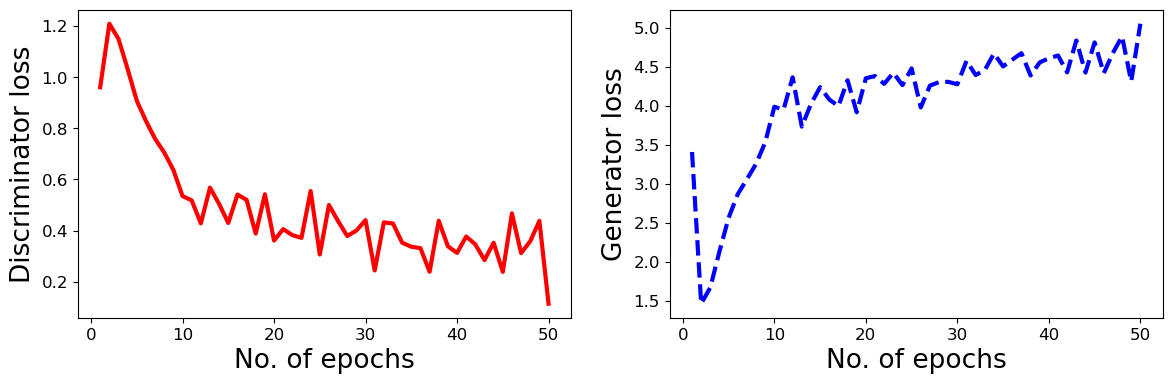

In [19]:
N = np.arange(n_epochs) + 1

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(N, discriminator_loss, 'r-', linewidth=3)
plt.xlabel('No. of epochs', fontsize=19)
plt.ylabel('Discriminator loss', fontsize=19)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.subplot(1, 2, 2)
plt.plot(N, generator_loss, 'b--', linewidth=3, label='Generator loss')
plt.xlabel('No. of epochs', fontsize=19)
plt.ylabel('Generator loss', fontsize=19)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

# 15. Generate samples from noise

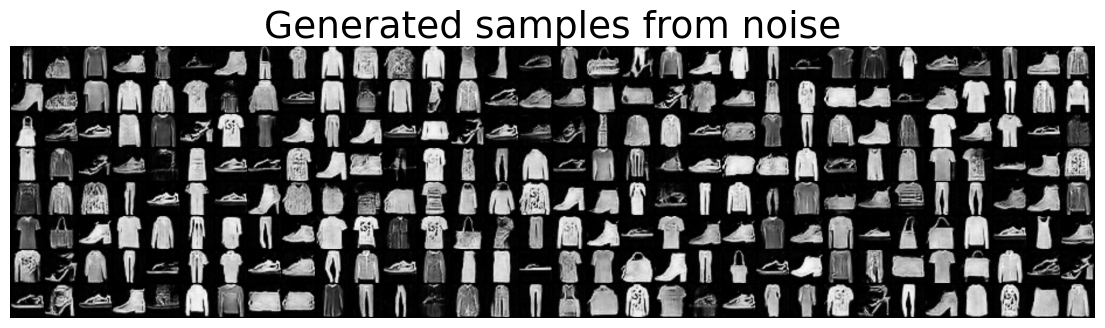

In [20]:
generator.eval()
n = torch.randn(256, 256, 1, 1)
random_samples = generator.cpu()(n)
grid = make_grid(random_samples, nrow=32, normalize=True)
plt.figure(figsize=(14, 6))
plt.imshow(grid.permute(1, 2, 0), cmap='gray')
plt.axis(False)
plt.title('Generated samples from noise', fontsize=27);